# Abrir imagen
Abrimos y mostramos imagen con open cv

Importamos librerías

In [1]:
import cv2
from matplotlib import pyplot as plt
import numpy as np

Abrimos fichero de imagen

In [51]:
# Ruta de la imagen
ruta_imagen =  "./descomprimido/Dataset/Frimar/bijou/ImagenGlobalCal_2024-01-29-16_27_09.jpeg"
#ruta_imagen =  "./descomprimido//Dataset/Furlani/ImagenGlobalCal_2024-09-05-17_33_42.jpeg"

# Leer imagen con OpenCV (por defecto en BGR)
imagen = cv2.imread(ruta_imagen)

# Comprobar si se cargó correctamente
if imagen is None:
    raise FileNotFoundError(f"No se pudo cargar la imagen en {ruta_imagen}")

Información sobre la imagen abierta del disco

In [52]:
def mostrar_informacion(imagen_mostrar):   
    # Obtener parámetros
    if (len(imagen_mostrar.shape) == 3): 
        alto, ancho, canales = imagen_mostrar.shape
    else:
        alto, ancho = imagen_mostrar.shape
        canales = 1
    tipo_dato = imagen_mostrar.dtype
    tamaño_bytes = imagen_mostrar.nbytes
    
    # Mostrar parámetros
    print(f"Dimensiones: {ancho} x {alto} píxeles")
    print(f"Canales: {canales} (3 = RGB/BGR, 1 = escala de grises)")
    print(f"Tipo de dato por píxel: {tipo_dato}")
    print(f"Tamaño en memoria: {tamaño_bytes / 1024:.2f} KB")

mostrar_informacion(imagen)

print(len(imagen.shape))


Dimensiones: 15000 x 4000 píxeles
Canales: 3 (3 = RGB/BGR, 1 = escala de grises)
Tipo de dato por píxel: uint8
Tamaño en memoria: 175781.25 KB
3


A pesar de ser una imagen en escala de grises tiene tres canales. Vamos a trabajar sobre un sólo canal. 

In [53]:
imagen_1_canal = imagen[:, :, 0] #np.expand_dims(imagen[:, :, 0], axis = -1)
mostrar_informacion(imagen_1_canal)


Dimensiones: 15000 x 4000 píxeles
Canales: 1 (3 = RGB/BGR, 1 = escala de grises)
Tipo de dato por píxel: uint8
Tamaño en memoria: 58593.75 KB


Mostramos la imagen

# Histrograma
Visualizamos el histograma:

(255, 1)
456750.0


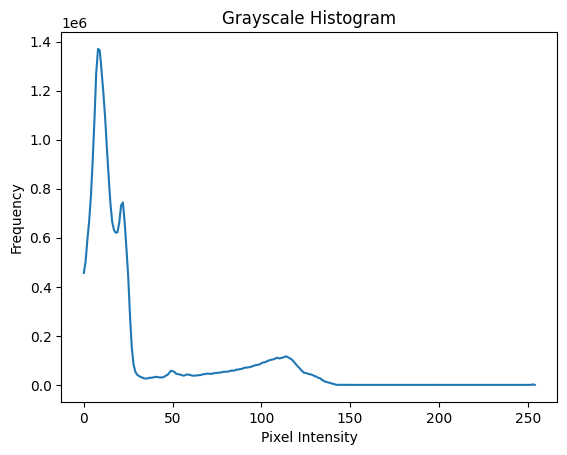

In [62]:
histogram = cv2.calcHist([imagen], [0], None, [255], [1, 255])

print(histogram.shape)
print(histogram[0 , 0])
#histogram[0, 0] = 0

plt.plot(histogram)
plt.title('Grayscale Histogram')
plt.xlabel('Pixel Intensity')
plt.ylabel('Frequency')
plt.show()


Buscamos picos y valles en el histograma.

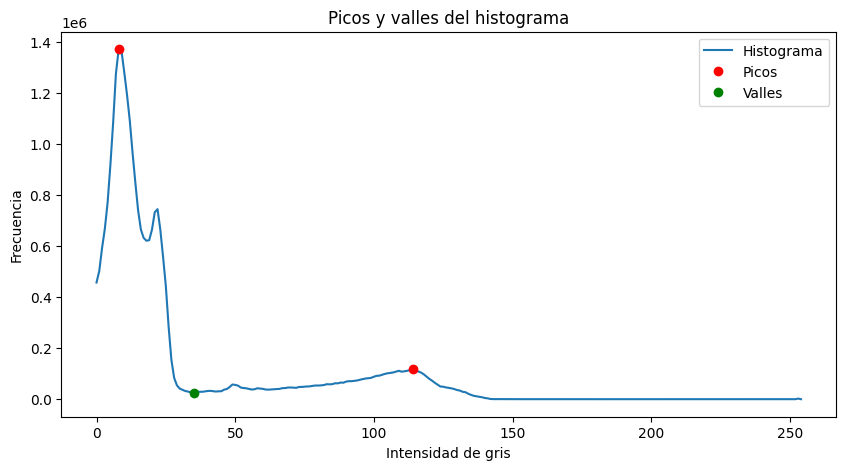

Picos: [  8 114]
Valles: [35]


In [63]:
from scipy.signal import find_peaks

def picos_valles(histograma):
    hist = histograma.flatten()
    distancia = 20
    prominencia = 40000
    
    # Buscar picos (máximos locales)
    picos, _ = find_peaks(hist, distance=distancia, prominence=prominencia)
    
    # Buscar valles (mínimos locales) invirtiendo la señal
    valles, _ = find_peaks(-hist, distance=distancia, prominence=prominencia)

    return picos, valles

peaks, valleys = picos_valles(histogram)

# Mostrar resultados
plt.figure(figsize=(10,5))
plt.plot(histogram, label="Histograma")
plt.plot(peaks, histogram[peaks], "ro", label="Picos")
plt.plot(valleys, histogram[valleys], "go", label="Valles")
plt.legend()
plt.xlabel("Intensidad de gris")
plt.ylabel("Frecuencia")
plt.title("Picos y valles del histograma")
plt.show()

# Imprimir coordenadas
print("Picos:", peaks)
print("Valles:", valleys)

Ultilizamos como valor para umbralizar la imagen el valle con mayor valor.

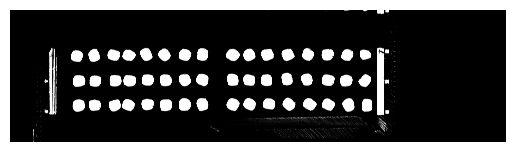

In [64]:
umbral = valleys[-1] # valor de umbral
valor_maximo = 255
_, imagen_umbralizada = cv2.threshold(imagen_1_canal, umbral, valor_maximo, cv2.THRESH_BINARY)
#_, imagen_umbralizada = cv2.threshold(imagen_1_canal, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
#imagen_umbralizada = cv2.adaptiveThreshold(imagen_1_canal, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 11, 2)

mostrar_imagen(imagen_umbralizada)

Creamos una imagen que muestre los bordes.

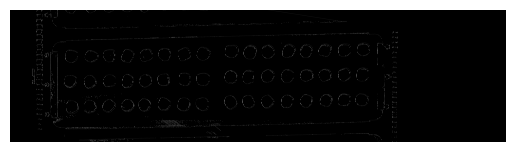

True

In [23]:
imagen_borde = cv2.Canny(imagen_1_canal,20, 200)

_, imagen_borde = cv2.threshold(imagen_borde, 20, valor_maximo, cv2.THRESH_BINARY)

mostrar_imagen(imagen_borde)
cv2.imwrite("bordes.jpg", imagen_borde)

In [ ]:
imagen_borde = cv2.Canny(imagen_1_canal,20, 200)

_, imagen_borde = cv2.threshold(imagen_borde, 20, valor_maximo, cv2.THRESH_BINARY)

print(imagen_borde.shape)
print(imagen_umbralizada.shape)

imagen_borde = cv2.bitwise_or(imagen_borde, imagen_umbralizada)

# Define a kernel (structuring element)
kernel = np.ones((5, 5), np.uint8)  # 5x5 square kernel

# Apply dilation
imagen_borde = cv2.dilate(imagen_borde, kernel, iterations=1)

mostrar_imagen(imagen_borde)
cv2.imwrite("bordes.jpg", imagen_borde)

In [24]:
# Find contours
contours, _ = cv2.findContours(imagen_umbralizada, 
                               cv2.RETR_EXTERNAL, 
                               cv2.CHAIN_APPROX_SIMPLE)

print(f"Blobs encontrados: {len(contours)}")

contour = contours[0]
x, y, w, h = cv2.boundingRect(contour)

print(f"Tamaños del blob: ({x}, {y}), ({w},{h})")

# imagen_barra = imagen_1_canal[x:x+w, y:y+h, :]

# mostrar_imagen(imagen_barra)

imagen_copia = imagen.copy()

# Iterate through contours to find bounding boxes
for contour in contours:
    # Get the bounding box for each contour
    x, y, w, h = cv2.boundingRect(contour)
    area = cv2.contourArea(contour)

    if (w < 100): continue
    if (w > 2000): continue
    if (h < 100): continue
    if (h > 2000): continue
    if (area < 40000): continue
    if (area > 800000): continue
    #if (h * w < 40000): continue
    #if (h * w > 800000): continue
    if (x <= 5): continue
    if (y <= 5): continue
    if (x + w - 5 >= imagen.shape[1]): continue
    if (y + h - 5 >= imagen.shape[0]): continue
    
    # Draw the bounding box on the original image
    cv2.rectangle(imagen_copia, (x, y), (x + w, y + h), (255, 0, 0), 2)

# Draw contours on the original image
cv2.drawContours(imagen_copia, contours, -1, (0, 255, 0), 2)

# Guardamos la imagen
cv2.imwrite("blobs2.jpg", imagen_copia)

Blobs encontrados: 2550
Tamaños del blob: (3549, 3988), (1,1)


True

Dimensiones: 15000 x 4000 píxeles
Canales: 1 (3 = RGB/BGR, 1 = escala de grises)
Tipo de dato por píxel: uint8
Tamaño en memoria: 58593.75 KB
Dimensiones: 471 x 464 píxeles
Canales: 1 (3 = RGB/BGR, 1 = escala de grises)
Tipo de dato por píxel: uint8
Tamaño en memoria: 213.42 KB


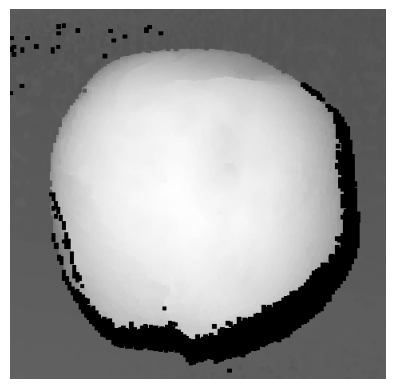

In [26]:
def get_imagen_barra(imagen_tabla, contorno):
    x, y, w, h = cv2.boundingRect(contorno)

    if (x < 50): return None
    if (y < 50): return None
    if (x+w+50 > imagen_1_canal.shape[1]) : return None
    if (y+h+50 > imagen_1_canal.shape[0]) : return None
    if (w < 100): return None
    if (h < 100): return None
    if (h * w < 100000): return None
    # imagen_barra = imagen_1_canal[x-50:x+w+50, y-50:y+h+50, :]
    return imagen_tabla[y-50:y+h+50, x-50:x+w+50]


for contour in contours:
    imagen_barra = get_imagen_barra(imagen_1_canal, contour)
    if imagen_barra is None: continue
    break
    
    # # Get the bounding box for each contour
    # x, y, w, h = cv2.boundingRect(contour)

    # if (x < 50): continue
    # if (y < 50): continue
    # if (x+w+50 > imagen_1_canal.shape[1]) : continue
    # if (y+h+50 > imagen_1_canal.shape[0]) : continue
    # if (w < 100): continue
    # if (h < 100): continue
    # if (h * w < 100000): continue
    # # imagen_barra = imagen_1_canal[x-50:x+w+50, y-50:y+h+50, :]
    # imagen_barra = imagen_1_canal[y-50:y+h+50, x-50:x+w+50]
    # print(f"Posicion: ({x}, {y})")
    # break


mostrar_informacion(imagen_1_canal)
mostrar_informacion(imagen_barra)
mostrar_imagen(imagen_barra)

In [31]:
from pathlib import Path
import os

# Grabamos las barras en disco
ruta_destino_barras = Path("barras")
os.makedirs(ruta_destino_barras, exist_ok=True)
numero_barra = 0

for contour in contours:
    imagen_barra = get_imagen_barra(imagen_1_canal, contour)
    if imagen_barra is None: continue
    cv2.imwrite(ruta_destino_barras/f"barra{numero_barra:03}.jpg", imagen_barra)
    numero_barra = numero_barra + 1

Para pasar las imágenes de tablas de una carpeta a imágenes de las barras seguimos los siguientes pasos:
1. Listamos los ficheros de imágenes de la carpeta

In [41]:
carpeta_barras = Path("descomprimido/Dataset/Frimar/bijou")
lista_ficheros = os.scandir(carpeta_barras)
valor_maximo_umbral = 255

ruta_destino_barras = Path("barras")
os.makedirs(ruta_destino_barras, exist_ok=True)

for i, fichero in enumerate(lista_ficheros):
    if not fichero.is_file(): continue
        
    # Leer imagen con OpenCV (por defecto en BGR)
    imagen = cv2.imread(fichero)

    # Comprobar si se cargó correctamente
    if imagen is None: continue

    #mostrar_imagen(imagen)

    # Trabajamos solo con un canal
    imagen_1_canal = imagen[:, :, 0]
    
    histogram = cv2.calcHist([imagen_1_canal], [0], None, [256], [1, 256])

    # plt.plot(histogram)
    # plt.title(f'Grayscale Histogram {i}')
    # plt.xlabel('Pixel Intensity')
    # plt.ylabel('Frequency')
    # plt.show()

    peaks, valleys = picos_valles(histogram)

    # Mostrar resultados
    # plt.figure(figsize=(10,5))
    # plt.plot(hist, label="Histograma")
    # plt.plot(peaks, histogram[peaks], "ro", label="Picos")
    # plt.plot(valleys, histogram[valleys], "go", label="Valles")
    # plt.legend()
    # plt.xlabel("Intensidad de gris")
    # plt.ylabel("Frecuencia")
    # plt.title(f"Picos y valles del histograma {i}")
    # plt.show()

    umbral = valleys[-1] # valor de umbral
    _, imagen_umbralizada = cv2.threshold(imagen_1_canal, umbral, valor_maximo_umbral, cv2.THRESH_BINARY)
    #_, imagen_umbralizada = cv2.threshold(imagen_1_canal, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    #imagen_umbralizada = cv2.adaptiveThreshold(imagen_1_canal, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 11, 2)

    print(f"Imagen {i}: {fichero.name}")
    #mostrar_imagen(imagen_umbralizada)

    # Find contours
    contours, _ = cv2.findContours(imagen_umbralizada, 
                               cv2.RETR_EXTERNAL, 
                               cv2.CHAIN_APPROX_SIMPLE)


    # Grabamos las barras en disco
    numero_barra = 0

    for contour in contours:
        imagen_barra = get_imagen_barra(imagen_1_canal, contour)
        if imagen_barra is None: continue
        cv2.imwrite(ruta_destino_barras/f"barra{i:02}{numero_barra:03}.jpg", imagen_barra)
        numero_barra = numero_barra + 1
    
    if i > 2 : break


Imagen 0: ImagenGlobalCal_2024-01-29-16_49_01.jpeg
Imagen 1: ImagenGlobalCal_2024-01-29-16_46_28.jpeg
Imagen 2: ImagenGlobalCal_2024-01-29-16_27_09.jpeg
Imagen 3: ImagenGlobalCal_2024-01-29-15_53_02.jpeg
